# MULTIPLE LINEAR REGRESSION

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats
from google.colab import files

In [31]:
df = pd.read_csv("salaries.csv")

In [32]:
#Data Cleaning
drop_cols = ['jobId', 'companyId', 'Unnamed: 8']  # known unnecessary
drop_cols += [col for col in df.columns if df[col].dtype == 'object'
              and col not in ['jobType', 'degree', 'major', 'industry']]
df.drop(columns=drop_cols, errors='ignore', inplace=True)

# Define features and target
target = 'salary'
X = df.drop(columns=[target])
y = df[target]

# Identify categorical and numerical columns
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [33]:
#Preprocessing Pipeline
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_cols),
        ('num', numerical_transformer, num_cols)
    ]
)


In [34]:
#Function to remove outliers (Z-score method)
def remove_outliers(df, columns, threshold=3):
    df_clean = df.copy()
    for col in columns:
        if col in df_clean.columns:
            z = np.abs(stats.zscore(df_clean[col]))
            df_clean = df_clean[z < threshold]
    return df_clean

In [35]:
#Model Evaluation Function
def evaluate_model(X_train, X_test, y_train, y_test, preprocess=False, remove_out=False):
    if remove_out:
        train_data = pd.concat([X_train, y_train], axis=1)
        train_data = remove_outliers(train_data, num_cols + [target])
        X_train = train_data.drop(columns=[target])
        y_train = train_data[target]

    if preprocess:
        model = Pipeline(steps=[('preprocessor', preprocessor),
                                ('regressor', LinearRegression())])
    else:
        model = LinearRegression()

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    return mae, mse, rmse, r2

In [36]:
#Split sizes and run experiments
split_ratios = [0.5, 0.4, 0.3, 0.2]
metrics = ['MAE', 'MSE', 'RMSE', 'R2']
results_with_df = pd.DataFrame(columns=['Train Size'] + metrics)
results_without_df = pd.DataFrame(columns=['Train Size'] + metrics)

for test_size in split_ratios:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Case 1: With preprocessing + outlier removal
    mae, mse, rmse, r2 = evaluate_model(X_train, X_test, y_train, y_test, preprocess=True, remove_out=True)
    results_with_df = pd.concat([results_with_df,
                                  pd.DataFrame([[1-test_size, mae, mse, rmse, r2]],
                                  columns=['Train Size'] + metrics)],
                                 ignore_index=True)

    # Case 2: Without preprocessing (numeric columns only)
    X_train_num = X_train[num_cols]
    X_test_num = X_test[num_cols]
    mae, mse, rmse, r2 = evaluate_model(X_train_num, X_test_num, y_train, y_test, preprocess=False, remove_out=False)
    results_without_df = pd.concat([results_without_df,
                                     pd.DataFrame([[1-test_size, mae, mse, rmse, r2]],
                                     columns=['Train Size'] + metrics)],
                                    ignore_index=True)

/tmp/ipython-input-1909418113.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_with_df = pd.concat([results_with_df,
/tmp/ipython-input-1909418113.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_without_df = pd.concat([results_without_df,


In [37]:
#Display results
print("\n=== With Preprocessing & Outlier Handling ===")
print(results_with_df)
print("\n=== Without Preprocessing ===")
print(results_without_df)



=== With Preprocessing & Outlier Handling ===
   Train Size        MAE         MSE       RMSE        R2
0         0.5  15.836730  384.806467  19.616485  0.743376
1         0.6  15.836516  384.829956  19.617083  0.743420
2         0.7  15.827107  384.355001  19.604974  0.744384
3         0.8  15.821597  383.984807  19.595530  0.744601

=== Without Preprocessing ===
   Train Size        MAE          MSE       RMSE        R2
0         0.5  27.476406  1155.163623  33.987698  0.229631
1         0.6  27.502691  1157.098847  34.016156  0.228519
2         0.7  27.550685  1159.894191  34.057219  0.228609
3         0.8  27.529046  1157.708371  34.025114  0.229975


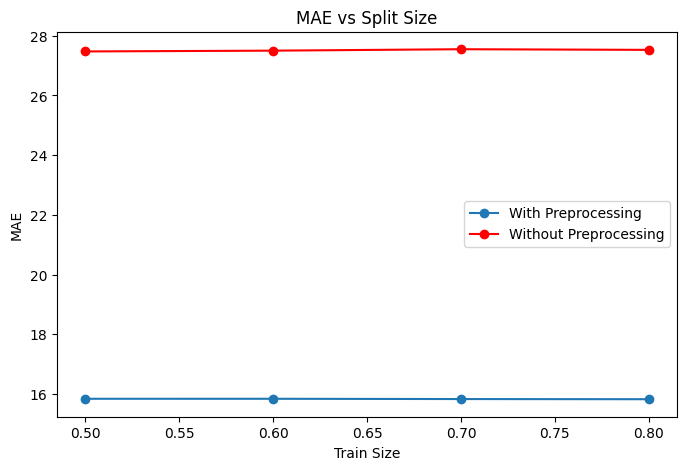

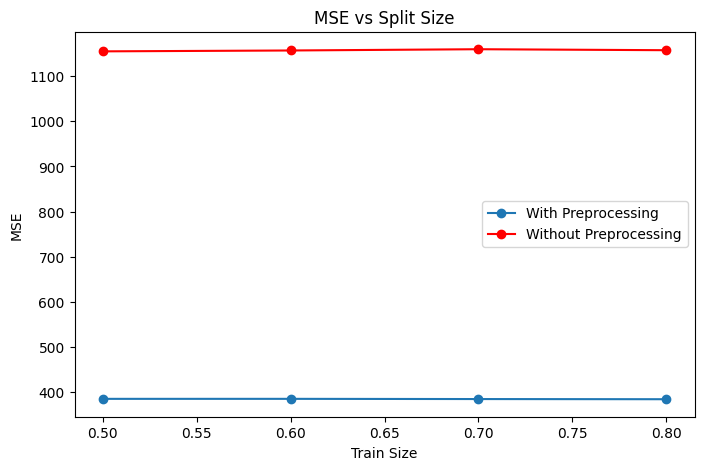

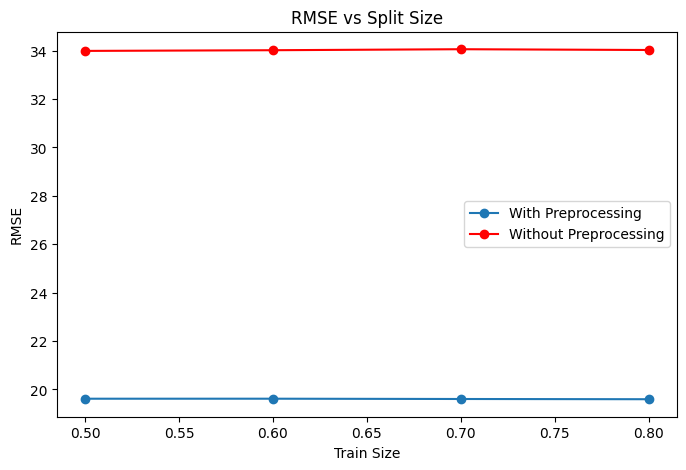

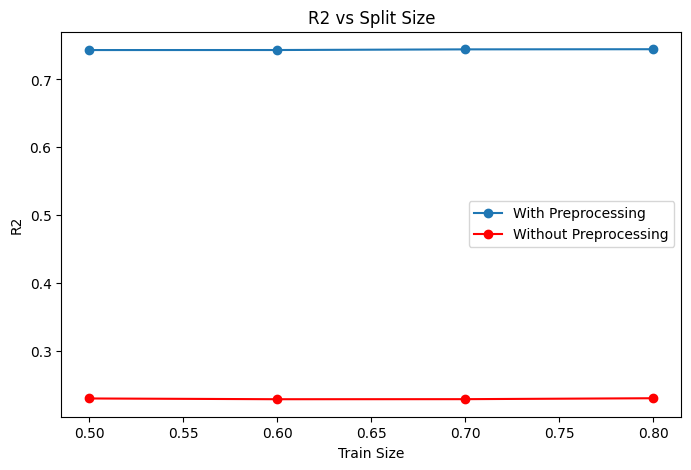

In [38]:
#Plot all metrics dynamically
for metric in metrics:
    plt.figure(figsize=(8,5))
    plt.plot(results_with_df['Train Size'], results_with_df[metric], marker='o', label='With Preprocessing')
    plt.plot(results_without_df['Train Size'], results_without_df[metric], marker='o', label='Without Preprocessing', color='red')
    plt.xlabel("Train Size")
    plt.ylabel(metric)
    plt.title(f"{metric} vs Split Size")
    plt.legend()
    plt.show()

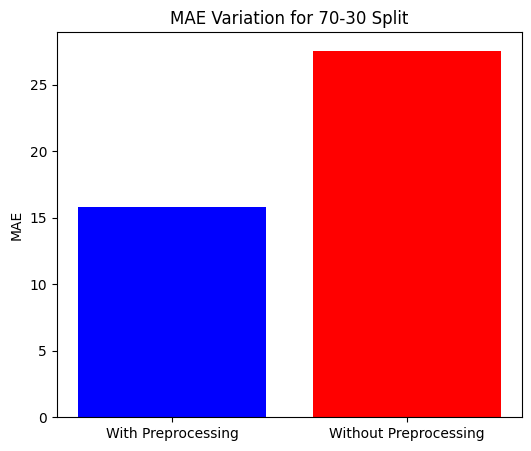

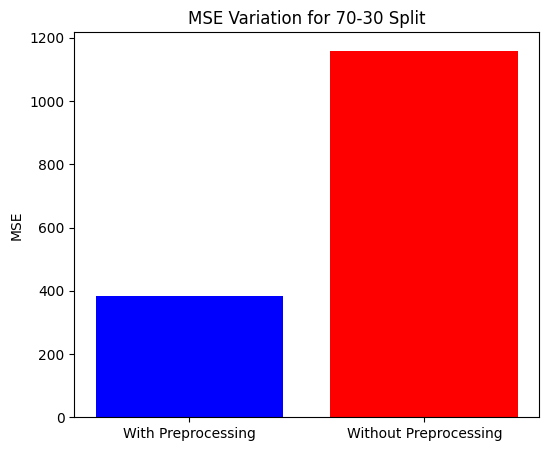

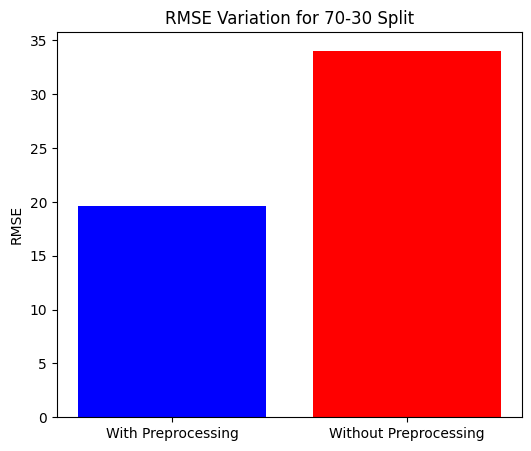

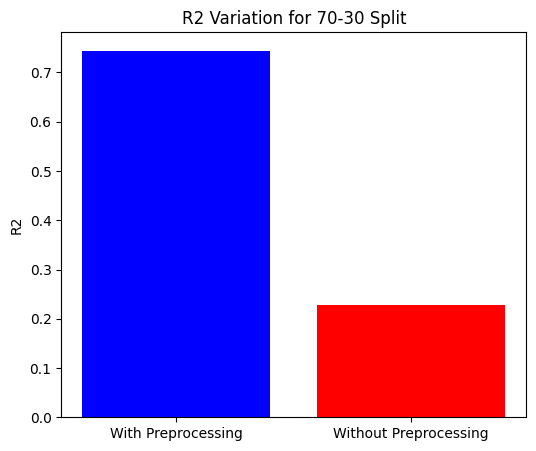

In [39]:
#Variation for one split size (choose 70-30 split)
split_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_size, random_state=42)

mae_w, mse_w, rmse_w, r2_w = evaluate_model(X_train, X_test, y_train, y_test, preprocess=True, remove_out=True)
mae_wo, mse_wo, rmse_wo, r2_wo = evaluate_model(X_train[num_cols], X_test[num_cols], y_train, y_test, preprocess=False, remove_out=False)

# STEP 11: Bar plots for all metrics for the 70-30 split
for metric, val_w, val_wo in zip(metrics, [mae_w, mse_w, rmse_w, r2_w], [mae_wo, mse_wo, rmse_wo, r2_wo]):
    plt.figure(figsize=(6,5))
    plt.bar(['With Preprocessing', 'Without Preprocessing'], [val_w, val_wo], color=['blue', 'red'])
    plt.ylabel(metric)
    plt.title(f"{metric} Variation for 70-30 Split")
    plt.show()